# Conditional GAN - MNIST

---

In this notebook will learn about Generative Adversarial Networks by implementing a conditional GAN to generate MNIST digits from noise.

**Important:** Set the Cloab environment to run on GPU

Author: Albert Pumarola

AIDL winter 2.019-2.020 Final Project

Team: Bargallo Enric, Navarro Alex, Planas Ramon, Treviño Nuria

Task: Conditional GAN - MNIST

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

## Utils
Some utils with minor importance

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

## Dataset
Download and prepare dataset


In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

## Data Loader
Create a data loader for the MNIST dataset

In [0]:
batch_size = 200
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

## Networks
First, lets define our simple generator

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
      
        self._fc = torch.nn.Linear(110, 1024*4*4)
        self.label_emb = nn.Embedding(10, 10)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, z, labels):
        # Noise to image + conditional labels
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)

        x = self._fc(x)
        #print(f"x.shape[0]: {x.shape[0]}")
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        return self._conv3(x)

Similarly lets define a simple discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_emb = nn.Embedding(10, 1024)
          
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Classify image as fake or real / EB: decision or judgement for fake or real?
        labels = self.label_emb(labels)
        labels = labels.view(labels.size(0),1,32,32)
        x = torch.cat([x, labels], dim=1)
        
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        return self._fc(x.view(-1, 512*4*4)) 

## Model
Now lets create the core of our task, the model.  Remember GANs loss:

$\underset{G}{\text{min}} \underset{D}{\text{max}}V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}\big[logD(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[log(1-D(G(z)))\big]$

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, z=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
            
        #generate fake samples out of the random noise z
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
        fake_samples = self._generator(z, fake_labels)

        return fake_samples
    
    def generator(self, z, label):
        sample = self._generator(z, label)
        return sample

    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples, labels):
        # generate fake samples + fake labels
        fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
        z = norm_noise(batch_size)
        fake_samples = self._generator(z, fake_labels)
        #fake_samples = self.generate_samples(real_samples.size(0))

        
        # optimize generator
        loss_g = self._step_opt_g(fake_samples, fake_labels)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, fake_samples.detach(), labels, fake_labels)
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, labels):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # Calculate generator loss - 2 lines
        estim_fake = self._discriminator(fake_samples, labels)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples, labels, fake_labels):
        # Reset gradients
        self._opt_d.zero_grad()

        # Calculate discriminator loss for real samples
        estim_real = self._discriminator(real_samples, labels)
        loss_real = self._criterion(estim_real, self._label_real)

        # Calculate discriminator loss for fake samples
        estim_fake = self._discriminator(fake_samples, fake_labels)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()
        
  

## Train

In [0]:
num_epochs = 30
num_val_samples = 25
z_val = norm_noise(num_val_samples)
model = Model(batch_size)

In [9]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samples, real_labels) in enumerate(data_loader):
        
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
        real_labels = Variable(real_labels).cuda()
          
        # Update model weights
        loss_g, loss_d = model.step_optimization(real_samples, real_labels)
        
        # Show current loss
        if (n_batch) % 50 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        #if (n_batch) % 100 == 0:
            #val_fake_samples = model.generate_samples(num_val_samples, z=z_val).data.cpu()
            #display_batch_images(val_fake_samples)

epoch: 0/30, batch: 0/300, G_loss: 0.6889280676841736, D_loss: (0.688183069229126, 0.6973925828933716)
epoch: 0/30, batch: 50/300, G_loss: 2.490622043609619, D_loss: (0.10270281136035919, 0.09022609889507294)
epoch: 0/30, batch: 100/300, G_loss: 1.1485490798950195, D_loss: (0.22167204320430756, 0.4599887728691101)
epoch: 0/30, batch: 150/300, G_loss: 2.612558364868164, D_loss: (0.4575235843658447, 0.09342794120311737)
epoch: 0/30, batch: 200/300, G_loss: 2.1645257472991943, D_loss: (0.6406660676002502, 0.1388041377067566)
epoch: 0/30, batch: 250/300, G_loss: 1.9466160535812378, D_loss: (0.6321413516998291, 0.1889229565858841)
epoch: 1/30, batch: 0/300, G_loss: 2.724048137664795, D_loss: (1.3150137662887573, 0.08432637155056)
epoch: 1/30, batch: 50/300, G_loss: 0.3680131435394287, D_loss: (0.14036621153354645, 1.4592289924621582)
epoch: 1/30, batch: 100/300, G_loss: 1.2405688762664795, D_loss: (0.7147563099861145, 0.4001283347606659)
epoch: 1/30, batch: 150/300, G_loss: 1.55145931243896

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9], device='cuda:0')


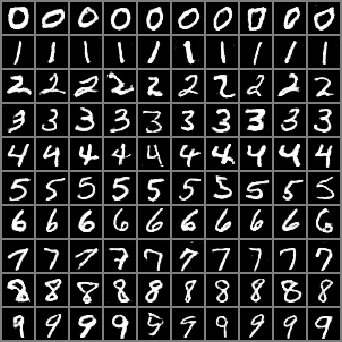

In [10]:
# Generate a matrix of 10x10 images from an ordered list of labels (10 vectors of 10 identic values from 0 to 9)
# The inputs to the model is random noise and the labels as the conditional factor 
z = Variable(torch.randn(100, 100)).cuda()
labels = torch.LongTensor([i for i in range(10) for num in range(10)]).cuda()
print(labels)
img = model.generator(z, labels).data.cpu()
display_batch_images(img)

